<a target="_blank" href="https://colab.research.google.com/github/wbfrench1/barker_DATA606/blob/main/src/proposal_eda.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Process

<ol><li>Get Data Locations and Filenames</li>
<li>Get Data and Save to Local Drive</li>
<li>Investigate the eng_train.bio dataset</li>
<ol><li>Label Data with Question Numbers</li>
<li>Separate the label field into two data elements: loc and pos</li>
<li>Identify the total number of questions - (9775)</li>
<li>Create Single Entities from Component Words</li></ol>
<li>Repeat the above steps with each for each of the datasets</li>
<li>Combine the data sets into one dataset</li>
<ol><li>Match up columns</li>
<li>Standardize columns</li>
<li>Combine Datasets</li></ol>

# EDA - Takeaways

<ol><li>There appears to be enough data.  Roughly 22,000 labeled movie trivia questions over two sets that are broken into training and test sets.</li>
<li>The entities between the two sets are mostly the same.  After making some adjustments, the final entities are ['outside', 'actor', 'year', 'title', 'genre', 'director', 'song', 'plot', 'review', 'character', 'rating', trailer', 'award','origin', 'relationship', 'quote']</li>
<li>Data must be cleaned (e.g. CHARACTER entity includes "adam sandler" and "adam sandlers"

In [164]:
import requests
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

In [3]:
def fetch_data( str_url: str, str_file_name_out: str):
    '''

    Description:    takes a string form to the url location of a dataset 
                    takes a string form of the filename to write the dataset to
                    saves the file to the working directory under the filename

    parameters:     str_url: a string containing the url of the data
                    str_file_name: a string containing the name the data will be
                       saved under in the current drive
    
    return:         Nothing
    ''' 
    r = requests.get(str_url, allow_redirects=True)
    open(str_file_name_out, 'wb').write(r.content)
    



def label_data_w_item_number ( str_f_name: str) -> pd.DataFrame:
    '''

    Description:    tags the same label to each word in a specific question to 
                       facilitate identification of unique questions later
                    saves the updated file
    
    Parameters:     str_f_name: takes the filename of one of the files in the 
                       trivia dataset and appends a question number to each word
                       that is part of the same question.
    
    return:         None

    '''

    with open(str_f_name) as f:
        lines = f.readlines()

    i = 1
    with open(str_f_name, 'w') as f_out:
        for line in lines:
            if line != '\n':
                # add a label for each question
                line = str(i) + '\t' + line
                f_out.write(line)
            else:
                i += 1
    



def separate_label_into_pos_and_entity_components(df: pd.DataFrame
                                                  ) -> pd.DataFrame:
    '''

    Description:    takes the label column which contains two variables and 
                        separates them into their two component pieces 
                        pos and entity
    
    Parameters:     df: takes a dataframe of labeled movie questions
    
    return:         dataframe with two new columns, pos and entity

    '''

    # adjust the O label to include a separate entity called other
    df.loc[df['label'] == 'O', 'label' ] = 'o-outside'
    # make everything lowercase
    df['label'] = df['label'].str.lower()
    # put the entity location of the word in new column 'pos' for position
    df['pos'] = [label[0] for label in df.label.str.split('-')]
    # put the entity type in a new column called 'entity'
    df['entity'] = [label[1] for label in df.label.str.split('-')]

    return df




def merge_entity_components_into_one (df: pd.DataFrame,
                                      l_entity_types : list) -> pd.DataFrame:
    '''

    Description:    takes a dataframe of labeled movie questions where the
                       the entity type (e.g. character, genre) has been 
                       separated from the position (B-beginning, I-intermediate)
                       and reassembles the entity into a single unit.
    
    Parameters:     df: takes a dataframe of labeled movie questions which has
                       an entity, quest_num, and word field
    
    return:         dataframe with two columns, entity and word, where word 
                       represents a single entity where B,I parts are 
                       reassembled

    '''


    df_label = pd.DataFrame()
    # loop through each entity type
    for entity in l_entity_types:
        # get the unique indicies associated with each entity
        for index in df.loc[df['entity'] == entity, 'quest_num'].unique():

            word = ' '.join([str(word) for word in df.loc[(df['quest_num'] == index)
                                    & (df['entity'] == entity), 'word'].tolist()])
            df_label2 = pd.DataFrame( { 'entity': entity, 'word' : word},index=[index])
            df_label = pd.concat([df_label,df_label2])
    
    return df_label


## 1. Data Locations and Filenames

In [4]:
str_url_1_train = 'https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio'
str_file_name_1_train = 'eng_train.bio'

str_url_1_test = 'https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio'
str_file_name_1_test = 'eng_test.bio'

str_url_2_train = 'https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio'
str_file_name_2_train = 'trivia_train.bio'

str_url_2_test = 'https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio'
str_file_name_2_test = 'trivia_test.bio'

l_data_urls_and_filenames = [(str_url_1_train, str_file_name_1_train),
                            (str_url_1_test, str_file_name_1_test),
                            (str_url_2_train, str_file_name_2_train),
                            (str_url_2_test, str_file_name_2_test)]

## 2. Get Data and Save to Local Drive
## 3. Investigate the eng_train.bio dataset
### 3.1 Label Data with Question Numbers

In [5]:
for str_url, str_f_name_out in l_data_urls_and_filenames:
    # 3. get data and save
    fetch_data( str_url = str_url,
            str_file_name_out = str_f_name_out)
    # label data with question numbers
    label_data_w_item_number( str_f_name = str_f_name_out)

In [6]:
df = pd.read_csv('eng_train.bio', sep='\t', names=['quest_num', 'label', 'word'])

#### Show an example that each question is now numbered

In [7]:
#https://datascientyst.com/set-caption-customize-font-size-color-in-pandas-dataframe/
styles = [dict(selector="caption", props=[("font-size", "120%"),
                                          ("font-weight", "bold")])]

df.loc[df['quest_num'] == random.randint(0,df['quest_num'].max()+1), ['quest_num', 'word','label']].rename(columns={'label': 'entity tag',}).style.set_caption("Movie Trivia Data Exemplar").set_table_styles(styles)

,quest_num,word,entity tag
65664,6673,list,O
65665,6673,all,O
65666,6673,movie,O
65667,6673,information,O
65668,6673,on,O
65669,6673,valmont,B-TITLE


In [8]:
df.label.unique()

array(['O', 'B-ACTOR', 'I-ACTOR', 'B-YEAR', 'B-TITLE', 'B-GENRE',
       'I-GENRE', 'B-DIRECTOR', 'I-DIRECTOR', 'B-SONG', 'I-SONG',
       'B-PLOT', 'I-PLOT', 'B-REVIEW', 'B-CHARACTER', 'I-CHARACTER',
       'B-RATING', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'I-TITLE',
       'I-RATING', 'B-TRAILER', 'I-TRAILER', 'I-REVIEW', 'I-YEAR'],
      dtype=object)

B = Begin
I = Intermediate
E = End

In [9]:
[dict(selector="caption", props=[("font-size", "120%"),
                                          ("font-weight", "bold")]),
dict(selector = 'th', props=[('text-align', 'left')])]

[{'selector': 'caption',
  'props': [('font-size', '120%'), ('font-weight', 'bold')]},
 {'selector': 'th', 'props': [('text-align', 'left')]}]

In [12]:
df_entity_tag_count = (
pd.DataFrame(df.rename(columns={'label': 'entity tag',}
                       ).groupby(['entity tag']
                                 )['entity tag'].count()
            ).rename(columns={'entity tag': 'count'}
                    ).sort_values(by='count', ascending=False
                                  )[:8].reset_index().style.set_properties(**{'text-align': 'left'})
)

#df_entity_tag_count.set_caption("Eng_Train.bio <br> Entity Count").set_table_styles(styles)

(df_entity_tag_count.set_caption("Entity Count<br> eng_train.bio "
                               ).set_table_styles([dict(selector="caption", 
                                                        props=[("font-size", "120%"),
                                                               ("font-weight", "bold")
                                                               ]
                                                        ),
                                                   dict(selector = 'th', 
                                                        props=[('text-align', 'left')]
                                                        )
                                                   ]
                                                  )).hide_index()

<ipython-input-12-4a5820f36796>:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  (df_entity_tag_count.set_caption("Entity Count<br> eng_train.bio "


entity tag,count
O,61008
B-GENRE,4354
I-TITLE,3495
I-ACTOR,3474
B-ACTOR,3220
B-YEAR,2858
I-YEAR,2456
B-TITLE,2376


In [13]:
df.label.value_counts()

O                    61008
B-GENRE               4354
I-TITLE               3495
I-ACTOR               3474
B-ACTOR               3220
B-YEAR                2858
I-YEAR                2456
B-TITLE               2376
B-RATING              2007
B-PLOT                1927
B-RATINGS_AVERAGE     1869
I-DIRECTOR            1850
B-DIRECTOR            1720
I-PLOT                1687
I-RATINGS_AVERAGE     1673
I-RATING               840
I-GENRE                786
I-SONG                 446
B-CHARACTER            385
I-CHARACTER            342
B-SONG                 245
B-REVIEW               221
I-REVIEW               132
B-TRAILER              113
I-TRAILER                7
Name: label, dtype: int64

### 3.2 Separate the label field into two data elements: loc and pos

In [14]:
df = separate_label_into_pos_and_entity_components(df)
df.sample(10)

,quest_num,label,word,pos,entity
92499,8928,i-actor,downey,i,actor
94605,9134,o-outside,starring,o,outside
17774,2174,o-outside,was,o,outside
72141,7243,i-title,shining,i,title
795,89,o-outside,movie,o,outside
21630,2622,o-outside,find,o,outside
4409,519,o-outside,movies,o,outside
50240,5390,i-ratings_average,right,i,ratings_average
71763,7207,b-genre,documentary,b,genre
65926,6697,o-outside,list,o,outside


In [15]:
df.loc[(df['quest_num'] == 2967)]

,quest_num,label,word,pos,entity
24733,2967,o-outside,find,o,outside
24734,2967,o-outside,a,o,outside
24735,2967,b-trailer,preview,b,trailer
24736,2967,o-outside,for,o,outside
24737,2967,o-outside,the,o,outside
24738,2967,o-outside,movie,o,outside
24739,2967,b-title,the,b,title
24740,2967,i-title,guns,i,title
24741,2967,i-title,of,i,title
24742,2967,i-title,navarone,i,title


### 3.3 Identify the total number of questions - (9775)

In [16]:
df['quest_num'].max()

9775

### 3.4 Create Single Entities from Component Words

BIO breaks entities up into beginning and intermediate pieces.  The below reassemblies the pieces into one entity.  Purpose is to understand the scope of the data set.

In [17]:
' '.join(df.loc[(df['quest_num'] == 2440)
        & (df['label'] == 'CHARACTER'), 'word'].tolist())

''

In [18]:
df.loc[df['label'] == 'CHARACTER', 'quest_num'].unique()

array([], dtype=int64)

In [19]:
l_entities = list(df['entity'].unique())
l_entities.remove('outside')
l_entities

['actor',
 'year',
 'title',
 'genre',
 'director',
 'song',
 'plot',
 'review',
 'character',
 'rating',
 'ratings_average',
 'trailer']

In [20]:
df_label = merge_entity_components_into_one(df,l_entities )

In [21]:
df_label.entity.value_counts()

genre              4341
actor              3080
year               2854
title              2371
rating             2000
plot               1896
ratings_average    1868
director           1711
character           361
song                235
review              218
trailer             113
Name: entity, dtype: int64

In [22]:
for entity in l_entities:
    print((df_label[df_label['entity'] == entity].value_counts()).sort_index()[:20], '\n\n')

entity  word                   
actor   2pac shakur                 1
        a j langer                  1
        aaliyah                     1
        aaron kwok                  2
        acted                       1
        actor                       4
        actors                      1
        adam sandler               16
        adam sandlers               1
        adam storke                 1
        adrian pasdar               1
        african american actor      1
        aidan quinn                 4
        al lewis                    1
        al pacimp robert deniro     1
        al pacino                  14
        al pacino robert deniro     1
        al pacinos                  1
        alan alda                   2
        alan aldas                  1
dtype: int64 


entity  word     
year    1800s          1
        1900s          1
        1920s          1
        1930           2
        1930s          5
        1933           1
        1939           1

## 4. Repeat the above steps with each for each of the datasets

In [23]:
dict_dfs = {}
dict_label_dfs = {}

for url, f_name in l_data_urls_and_filenames:
    print(f_name)
    dict_dfs[('df_'+ f_name.split('.')[0])] = pd.read_csv(f_name, sep='\t', names=['quest_num', 'label', 'word'])
    dict_dfs[('df_'+ f_name.split('.')[0])] = separate_label_into_pos_and_entity_components(dict_dfs[('df_'+ f_name.split('.')[0])])
    print('\n','Number of Questions: ', dict_dfs[('df_'+ f_name.split('.')[0])]['quest_num'].max(),'\n', sep='')
    l_entities = list(dict_dfs[('df_'+ f_name.split('.')[0])]['entity'].unique())
    l_entities.remove('outside')
    dict_label_dfs[('df_label_'+ f_name.split('.')[0])]= merge_entity_components_into_one(dict_dfs[('df_'+ f_name.split('.')[0])],l_entities )
    print('\n', dict_label_dfs[('df_label_'+ f_name.split('.')[0])].entity.value_counts(), '\n\n\n', sep='')

eng_train.bio

Number of Questions: 9775


genre              4341
actor              3080
year               2854
title              2371
rating             2000
plot               1896
ratings_average    1868
director           1711
character           361
song                235
review              218
trailer             113
Name: entity, dtype: int64



eng_test.bio

Number of Questions: 2443


genre              1115
actor               763
year                719
title               562
rating              498
plot                487
director            456
ratings_average     449
character            85
review               54
song                 51
trailer              30
Name: entity, dtype: int64



trivia_train.bio

Number of Questions: 7816


plot              5980
actor             3627
genre             3297
year              2688
director          1742
character_name     812
opinion            766
origin             731
relationship       524
award              261
quo

In [24]:
df.shape

(99491, 5)

In [25]:
dict_label_dfs.keys()

dict_keys(['df_label_eng_train', 'df_label_eng_test', 'df_label_trivia_train', 'df_label_trivia_test'])

In [26]:
dict_label_dfs['df_label_trivia_train']

,entity,word
1,actor,steve mcqueen
2,actor,liza minnelli joel gray
3,actor,tom hanks julia roberts
6,actor,mel gibson
9,actor,julie andre dick van dyke
...,...,...
7640,quote,it put s the fu in kung fu
7763,quote,make my day
7775,quote,the first rule is to not talk about it
7800,quote,why were the pacifists so easily turned to mur...


In [27]:
dict_dfs['df_eng_test'].head()

,quest_num,label,word,pos,entity
0,1,o-outside,are,o,outside
1,1,o-outside,there,o,outside
2,1,o-outside,any,o,outside
3,1,o-outside,good,o,outside
4,1,b-genre,romantic,b,genre


In [28]:
dict_dfs['df_trivia_train']

,quest_num,label,word,pos,entity
0,1,b-actor,steve,b,actor
1,1,i-actor,mcqueen,i,actor
2,1,o-outside,provided,o,outside
3,1,o-outside,a,o,outside
4,1,b-plot,thrilling,b,plot
...,...,...,...,...,...
158818,7816,i-origin,on,i,origin
158819,7816,i-origin,a,i,origin
158820,7816,i-origin,nicholas,i,origin
158821,7816,i-origin,sparks,i,origin


In [29]:
(dict_label_dfs[('df_label_eng_test')].entity.value_counts())

genre              1115
actor               763
year                719
title               562
rating              498
plot                487
director            456
ratings_average     449
character            85
review               54
song                 51
trailer              30
Name: entity, dtype: int64

In [30]:
pd.read_csv('trivia_train.bio', sep='\t', names=['quest_num', 'label', 'word'])

,quest_num,label,word
0,1,B-Actor,steve
1,1,I-Actor,mcqueen
2,1,O,provided
3,1,O,a
4,1,B-Plot,thrilling
...,...,...,...
158818,7816,I-Origin,on
158819,7816,I-Origin,a
158820,7816,I-Origin,nicholas
158821,7816,I-Origin,sparks


In [31]:
print('eng dataset contains {:,} questions.'.format(9775 + 2443,))
print('trivia dataset contains {:,} questions.'.format(7816 + 1953,))

eng dataset contains 12,218 questions.
trivia dataset contains 9,769 questions.


In [32]:
dict_dfs.keys()

dict_keys(['df_eng_train', 'df_eng_test', 'df_trivia_train', 'df_trivia_test'])

## 5. Combine the data sets into one dataset

### 5.1 Match up columns
### 5.2 Standardize columns

In [33]:
dict_label_dfs.keys()

dict_keys(['df_label_eng_train', 'df_label_eng_test', 'df_label_trivia_train', 'df_label_trivia_test'])

In [34]:
# allow identification of the source
dict_dfs['df_eng_train']['source'] = 'eng_train'
dict_dfs['df_eng_test'] ['source']= 'eng_test'
dict_label_dfs['df_label_eng_train']['source'] = 'label_eng_train'
dict_label_dfs['df_label_eng_test']['source'] = 'df_label_eng_test'

In [35]:
df_eng_total = dict_dfs['df_eng_train'].append(dict_dfs['df_eng_test'])
df_label_eng_total = dict_label_dfs['df_label_eng_train'].append(dict_label_dfs['df_label_eng_test'])

<ipython-input-35-263766eeca6a>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_eng_total = dict_dfs['df_eng_train'].append(dict_dfs['df_eng_test'])
<ipython-input-35-263766eeca6a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_eng_total = dict_label_dfs['df_label_eng_train'].append(dict_label_dfs['df_label_eng_test'])


#### df_eng_total

In [36]:
df_eng_total.shape

(124177, 6)

In [37]:
df_eng_total.entity.unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'ratings_average',
       'trailer'], dtype=object)

#### df_trivia_total

In [38]:
# allow identification of the source
dict_dfs['df_trivia_train']['source'] = 'trivia_train'
dict_dfs['df_trivia_test'] ['source']= 'trivia_test'
dict_label_dfs['df_label_trivia_train']['source'] = 'label_trivia_train'
dict_label_dfs['df_label_trivia_test']['source'] = 'df_label_trivia_test'

In [39]:
df_trivia_total = dict_dfs['df_trivia_train'].append(dict_dfs['df_trivia_test'])
df_label_trivia_total = dict_label_dfs['df_label_trivia_train'].append(dict_label_dfs['df_label_trivia_test'])

<ipython-input-39-d0fe4b8500b1>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_trivia_total = dict_dfs['df_trivia_train'].append(dict_dfs['df_trivia_test'])
<ipython-input-39-d0fe4b8500b1>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_trivia_total = dict_label_dfs['df_label_trivia_train'].append(dict_label_dfs['df_label_trivia_test'])


In [40]:
df_trivia_total.shape

(197858, 6)

### 5.1 Match up columns

In [41]:
df_trivia_total.entity.unique()

array(['actor', 'outside', 'plot', 'opinion', 'award', 'year', 'genre',
       'origin', 'director', 'soundtrack', 'relationship',
       'character_name', 'quote'], dtype=object)

|eng variable            |trivia variable  | description                          |
| ---------------------- | -----------| ---                                  |
|outside                 | outside    | untracked entity                     |
|actor                   |  actor     | person's name acting in the movie |
| year                   |  year      | two and four digit years         |      
| genre                  | genre      | movie's subject matter               |
| director               | director   | person's name in charge of movie     |
| song                   | soundtrack | song's in a movie                    |
| plot                   | plot       | movie's story line                   |
| review, ratings_average| opinion    | words describing the movie           |
| character              | character_name| person's name in movie story line |
| rating                 | na         | classification of movie appropriateness for different age groups
| na                     | award      | recognition for acheivement in a given category
| na                     | origin     | source of inspiration for movie script |
| na                     | relationship| how movie is related to other movies in the same story line

In [42]:
df_label_eng_total.loc[df_label_eng_total['entity'] == 'year' ].value_counts()[:10]

entity  word    source         
year    1950 s  label_eng_train    102
        1970 s  label_eng_train    100
        1980 s  label_eng_train     94
        1990 s  label_eng_train     93
        1960 s  label_eng_train     93
        2010 s  label_eng_train     91
        2010    label_eng_train     89
        1990s   label_eng_train     81
        2000    label_eng_train     78
        2000 s  label_eng_train     77
dtype: int64

In [43]:
df_label_trivia_total.loc[(df_label_trivia_total['entity'] == 'relationship')].value_counts()[:20]

entity        word                     source              
relationship  sequel                   label_trivia_train      95
                                       df_label_trivia_test    33
              remake                   label_trivia_train      31
                                       df_label_trivia_test    10
              remade                   label_trivia_train       8
              prequel                  label_trivia_train       7
              franchise                label_trivia_train       7
              third installment        label_trivia_train       5
              first movie              df_label_trivia_test     4
              third movie              label_trivia_train       4
              reboot                   label_trivia_train       4
              final installment        label_trivia_train       4
              second installment       label_trivia_train       4
                                       df_label_trivia_test     4
              fi

In [44]:
df_eng_total.loc[df_eng_total['entity'] == 'ratings_average', 'word'].value_counts()[:20]

stars      336
good       234
rated      191
highly     179
liked      165
well       137
nine       128
very       125
really     123
six        119
eight      119
popular    117
seven      109
four       108
ratings    103
five       102
average     93
ok          81
by          73
star        73
Name: word, dtype: int64

In [45]:
df_trivia_total.loc[df_trivia_total['entity'] == 'award', 'word'].unique()[:50]

array(['won', 'oscars', 'oscar', 'for', 'writing', 'academy', 'award',
       'best', 'actor', 'awards', 'documentary', 'winner', 'picture',
       'animated', 'feature', 'nominated', 'winning', 'the', 'foreign',
       'language', 'film', 'several', 'including', 'many', '9',
       'original', 'screenplay', 'at', 'director', '2', 'two', '82', 'nd',
       'score', 'supporting', 'acress', 'five', 'actress', 'nomination',
       'and', 'four', 'time', 'to', 'win', 'leading', 'role', 'acadamy',
       'lost', 'crash', 'one'], dtype=object)

#### Song to Soundtrack Comparison

In [46]:
df_eng_total.loc[df_eng_total['entity'] == 'song', 'word'].unique()[:50]

array(['leonard', 'cohen', 'songs', 'soundtrack', 'beyonce', 'rock',
       'song', 'day', 'by', 'i', 'will', 'always', 'love', 'you', 'trent',
       'reznor', 'suicide', 'is', 'painless', 'blaze', 'of', 'glory',
       'john', 'williams', 'the', 'one', 'youre', 'with', 'blue',
       'hawaii', 'ice', 'baby', 'theme', 'coolio', 'satisfaction', 'your',
       'touch', 'black', 'keys', 'original', 'score', 'somewhere', 'out',
       'there', 'beatles', 'abba', 'rick', 'springfield', 'my', 'heart'],
      dtype=object)

In [47]:
df_trivia_total.loc[df_trivia_total['entity'] == 'soundtrack', 'word'].unique()[:50] 

array(['famous', 'song', 'by', 'the', 'beatles', 'hakunamatata', 'avril',
       'lavigne', 'courtesy', 'of', 'bee', 'music', 'written', 'elton',
       'john', 'with', 'lyrics', 'hills', 'are', 'alive', 'score',
       'williams', 'white', 'christmas', 'hakuna', 'matata', 'can', 'you',
       'feel', 'love', 'tonight', 'raindrops', 'keep', 'falling', 'on',
       'my', 'head', 'cole', 'porter', 'night', 'and', 'day',
       'soundtrack', 'composer', 'hans', 'zimmer', 'classical', 'i', 'm',
       'going'], dtype=object)

#### Review Comparison

In [48]:
df_eng_total.loc[df_eng_total['entity'] == 'review', 'word'].unique()[:50]

array(['must', 'watch', 'popular', 'oscar', 'good', 'best', 'most', 'see',
       'famous', 'funniest', 'well', 'known', 'awful', 'movie', 'similar',
       'top', 'rated', 'greatest', 'appropriate', 'five', 'star', 'funny',
       'lowest', 'about', 'scariest', 'recommended', 'ten', 'great',
       'less', 'than', '10', 'positive', 'considered', 'the', 'classic',
       'loved', 'really', 'rating', 'like', 'highest', 'worst', 'highly',
       'worth', 'watching', 'three', 'movies', 'feel', 'critically',
       'acclaimed', 'everyone'], dtype=object)

In [49]:
df_trivia_total.loc[df_trivia_total['entity'] == 'opinion', 'word'].unique()[:50] 

array(['greatest', 'of', 'all', 'blockbuster', 'pivotal', 'famous',
       'shower', 'scene', 'in', 'cinematic', 'history', 'epic', 'classic',
       'first', 'box', 'office', 'success', 'highly', 'popular',
       'emotionally', 'devastating', 'best', 'film', 'ever', 'made',
       'very', 'masterpiece', 'female', 'friendly', 'playful', 'high',
       'quality', 'low', 'rated', 'considered', 'to', 'be', 'one', 'the',
       'films', 'time', 'series', 'huge', 'hit', 'ultra', 'violent',
       'controversial', 'but', 'well', 'received'], dtype=object)

### 5.2 Standardize Entities

In [50]:
df_trivia_total.columns

Index(['quest_num', 'label', 'word', 'pos', 'entity', 'source'], dtype='object')

In [51]:
df_trivia_total['entity'].unique()

array(['actor', 'outside', 'plot', 'opinion', 'award', 'year', 'genre',
       'origin', 'director', 'soundtrack', 'relationship',
       'character_name', 'quote'], dtype=object)

In [52]:
l_bio = ['i', 'b']
l_trivia_entities_to_update = ['soundtrack', 'character_name',
                               'opinion']
l_trivia_entities_updated = ['song','character','review']

l_beg_trivia_ents = [bio + '-' + ent for bio in l_bio for ent in l_trivia_entities_to_update]

l_end_trivia_ents = [bio + '-' + ent for bio in l_bio for ent in l_trivia_entities_updated]

dict_label_updates = dict(zip(l_beg_trivia_ents,l_end_trivia_ents))

In [53]:
df_trivia_total['entity'].replace({'soundtrack': 'song',
                                   'character_name' : 'character',
                                   'opinion' : 'review'}, inplace=True)

df_trivia_total['label'].replace(dict_label_updates, inplace=True)

In [54]:
df_trivia_total['entity'].unique()

array(['actor', 'outside', 'plot', 'review', 'award', 'year', 'genre',
       'origin', 'director', 'song', 'relationship', 'character', 'quote'],
      dtype=object)

In [55]:
df_eng_total['entity'].unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'ratings_average',
       'trailer'], dtype=object)

In [56]:
df_eng_total['entity'].replace({'ratings_average' : 'rating'}, inplace=True)

In [57]:
df_eng_total['entity'].unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'trailer'], dtype=object)

In [58]:
df_eng_total.label.unique()

array(['o-outside', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre',
       'i-genre', 'b-director', 'i-director', 'b-song', 'i-song',
       'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character',
       'b-rating', 'b-ratings_average', 'i-ratings_average', 'i-title',
       'i-rating', 'b-trailer', 'i-trailer', 'i-review', 'i-year'],
      dtype=object)

In [59]:
df_eng_total.replace({'i-ratings_average': 'i-review',
                      'b-ratings_average': 'b-review'},
                     inplace=True)

### 5.3 Combine datasets 

In [60]:
df_eng_total.columns

Index(['quest_num', 'label', 'word', 'pos', 'entity', 'source'], dtype='object')

##### Ensure that variables and values match

In [61]:
df_trivia_total.columns

Index(['quest_num', 'label', 'word', 'pos', 'entity', 'source'], dtype='object')

In [62]:
df_eng_total.label.unique()

array(['o-outside', 'b-actor', 'i-actor', 'b-year', 'b-title', 'b-genre',
       'i-genre', 'b-director', 'i-director', 'b-song', 'i-song',
       'b-plot', 'i-plot', 'b-review', 'b-character', 'i-character',
       'b-rating', 'i-review', 'i-title', 'i-rating', 'b-trailer',
       'i-trailer', 'i-year'], dtype=object)

In [63]:
df_trivia_total.label.unique()

array(['b-actor', 'i-actor', 'o-outside', 'b-plot', 'i-plot', 'b-review',
       'i-review', 'b-award', 'i-award', 'b-year', 'b-genre', 'b-origin',
       'i-origin', 'b-director', 'i-director', 'i-genre', 'i-year',
       'b-song', 'i-song', 'b-relationship', 'i-relationship',
       'b-character', 'i-character', 'b-quote', 'i-quote'], dtype=object)

In [64]:
# in eng but not trivia
np.setdiff1d(df_eng_total.label.unique(),df_trivia_total.label.unique())

array(['b-rating', 'b-title', 'b-trailer', 'i-rating', 'i-title',
       'i-trailer'], dtype=object)

In [65]:
# in trivia but not eng
np.setdiff1d(df_trivia_total.label.unique(),df_eng_total.label.unique())

array(['b-award', 'b-origin', 'b-quote', 'b-relationship', 'i-award',
       'i-origin', 'i-quote', 'i-relationship'], dtype=object)

In [66]:
df = df_eng_total.append(df_trivia_total)

<ipython-input-66-dacb9c7ca904>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_eng_total.append(df_trivia_total)


In [67]:
i = 1
df['q_num'] = 0
for source in df.source.unique():
    print(source)
    for quest_num in df.loc[(df['source'] == source), 'quest_num'].unique():
        df.loc[(df['source'] == source)
               & (df['quest_num'] == quest_num),'q_num'
              ] = i
        i += 1          

eng_train
eng_test
trivia_train
trivia_test


In [119]:
source = 'eng_test'
quest_num = (2443)

df.loc[(df['source'] == source)
               & (df['quest_num'] == quest_num)]

,quest_num,iob2_label,word,pos,entity,source,q_num
124166,2443,o-outside,what,o,outside,eng_test,12218
124167,2443,o-outside,s,o,outside,eng_test,12218
124168,2443,o-outside,the,o,outside,eng_test,12218
124169,2443,o-outside,title,o,outside,eng_test,12218
124170,2443,o-outside,of,o,outside,eng_test,12218
124171,2443,o-outside,the,o,outside,eng_test,12218
124172,2443,o-outside,movie,o,outside,eng_test,12218
124173,2443,o-outside,about,o,outside,eng_test,12218
124174,2443,b-character,captain,b,character,eng_test,12218
124175,2443,i-character,jack,i,character,eng_test,12218


In [70]:
df.to_csv('movie_data.csv', index=False)

In [111]:
df = pd.read_csv('movie_data.csv')

In [112]:
l_entities = list(df.entity.unique())
l_entities

['outside',
 'actor',
 'year',
 'title',
 'genre',
 'director',
 'song',
 'plot',
 'review',
 'character',
 'rating',
 'trailer',
 'award',
 'origin',
 'relationship',
 'quote']

In [113]:
df = separate_label_into_pos_and_entity_components(df)

In [117]:
df.rename(columns={'label' : 'iob2_label'}, inplace= True)
df.loc[df['q_num'] == 2]

,quest_num,iob2_label,word,pos,entity,source,q_num
5,2,o-outside,show,o,outside,eng_train,2
6,2,o-outside,me,o,outside,eng_train,2
7,2,o-outside,films,o,outside,eng_train,2
8,2,o-outside,with,o,outside,eng_train,2
9,2,b-actor,drew,b,actor,eng_train,2
10,2,i-actor,barrymore,i,actor,eng_train,2
11,2,o-outside,from,o,outside,eng_train,2
12,2,o-outside,the,o,outside,eng_train,2
13,2,b-year,1980s,b,year,eng_train,2


In [123]:
df_entity_tag_count = (
pd.DataFrame(df.rename(columns={'iob2_tag': 'iob2_label',}
                       ).groupby(['iob2_label']
                                 )['iob2_label'].count()
            ).rename(columns={'iob2_label': 'count'}
                    ).sort_values(by='count', ascending=False
                                  )[:8].reset_index().style.set_properties(**{'text-align': 'left'})
)

#df_entity_tag_count.set_caption("Eng_Train.bio <br> Entity Count").set_table_styles(styles)

(df_entity_tag_count.set_caption("IOB2_Label Count<br> Combined_Dataset "
                               ).set_table_styles([dict(selector="caption", 
                                                        props=[("font-size", "120%"),
                                                               ("font-weight", "bold")
                                                               ]
                                                        ),
                                                   dict(selector = 'th', 
                                                        props=[('text-align', 'left')]
                                                        )
                                                   ]
                                                  )).hide_index()

<ipython-input-123-7fe424e9e0b6>:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  (df_entity_tag_count.set_caption("IOB2_Label Count<br> Combined_Dataset "


iob2_label,count
o-outside,145975
i-plot,78951
i-actor,12010
b-plot,10463
b-actor,10316
b-genre,9644
b-year,6941
i-director,4410


In [ ]:
df.entity.unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'trailer', 'award',
       'origin', 'relationship', 'quote'], dtype=object)

## iob2_label Count - All Data

In [80]:
df_all = df.copy()

In [79]:
df_label = merge_entity_components_into_one(df,l_entities )

In [189]:
df_label = pd.read_csv('https://github.com/wbfrench1/barker_DATA606/blob/26c34fe90fbb30f41e486a831176f72bf22f3048/data/df_combined_data_w_merged_entities.csv?raw=true')

In [190]:
df_label.entity.unique()

array(['outside', 'actor', 'year', 'title', 'genre', 'director', 'song',
       'plot', 'review', 'character', 'rating', 'trailer', 'award',
       'origin', 'relationship', 'quote'], dtype=object)

In [109]:
df_label.loc[df_label.entity != 'outside'].sample(5)

,entity,word
1854,actor,tim curry susan sarrandon tim mcgraw
6550,plot,samurai takes place in morocco
7996,director,christophe gans
5862,review,four
3166,actor,clark gable


In [154]:
df_label['entity'].value_counts().sort_values(ascending=False)

outside         9646
plot            7004
genre           6849
actor           6013
year            5401
director        3752
review          3221
title           2764
rating          2467
character       1394
origin           896
relationship     656
song             334
award            312
quote            162
trailer          142
Name: entity, dtype: int64

In [156]:
df_entity_count = df_label['entity'].value_counts().sort_values(ascending=True).reset_index().copy()
df_entity_count.rename(columns={'entity': 'count','index': 'entity', }, inplace=True)
df_entity_count.sort_values(by='count', ascending=False, inplace=True)
df_entity_count

,entity,count
15,outside,9646
14,plot,7004
13,genre,6849
12,actor,6013
11,year,5401
10,director,3752
9,review,3221
8,title,2764
7,rating,2467
6,character,1394


Text(0.5, 1.0, 'Movie Entity Count Combined Dataset')

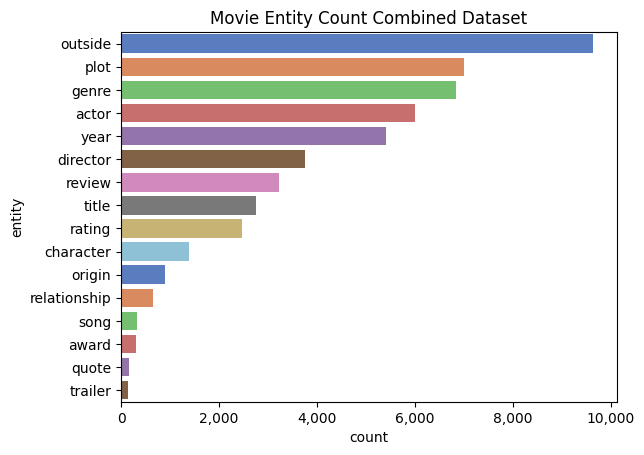

In [186]:
g = sns.barplot(data=df_entity_count, x='count', y='entity',
            palette= 'muted')

g.axes.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{int(x):,}'))
g.set_title('Movie Entity Count Combined Dataset')

- project business proposal

  - Literature Search
  - Run the Models
  - Show the results
  - Several Identify techniques for improvement
  - Implement techniques
  - Look at results
  - Appropriate Visualizatio of results
  
- eda -for each data set explain the data. 

  - Show the labels
  - Show the titles and counts